In [112]:
from datasets import load_dataset
from matplotlib import pyplot as plt
import torch
def get_data():
    import numpy as np
    dataset = load_dataset(path="D:\study\gen.1.celeba", split='train')
    dataset = dataset.shuffle(0).select(range(2000))
    def f(data):
        images = data['image']
        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i-127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}
    dataset = dataset.map(function=f, batched=True, batch_size=1000, num_proc=4, remove_columns=list(dataset.features)[1:])
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(2000):
        data[i] = dataset[i]['image']
    return data
data = get_data()
print(data.shape, data.min(), data.max())
loader = torch.utils.data.DataLoader(dataset=data, batch_size=64, shuffle=True, drop_last=True)

(2000, 3, 64, 64) -1.0 1.0


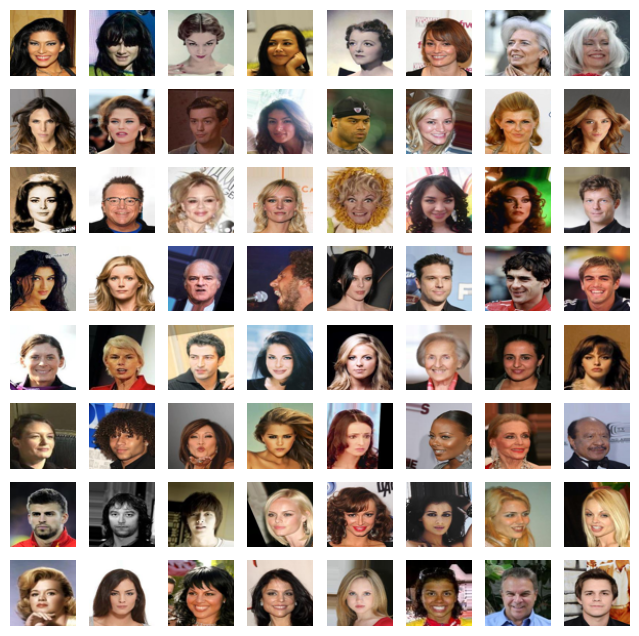

In [113]:
def show(images):
    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()
    plt.figure(figsize=(8, 8))
    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1)/2
        plt.subplot(8, 8, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
show(next(iter(loader)))

In [140]:
class Block(torch.nn.Module):
    def __init__(self, dim_in, dim_out, is_encoder=True):
        super().__init__()
        cnn_type = torch.nn.Conv2d
        if not is_encoder:
            cnn_type = torch.nn.ConvTranspose2d
            
        def block(dim_in, dim_out, kernel_size=3, stride=1, padding=1):
            x = cnn_type(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding)
            batchnorm = torch.nn.BatchNorm2d(dim_out)
            act_fn = torch.nn.LeakyReLU()
            return x, batchnorm, act_fn
            
        self.s = torch.nn.Sequential(
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_out, kernel_size=3, stride=2, padding=0),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out)            
        )
        self.res = cnn_type(dim_in, dim_out, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        return self.s(x) + self.res(x)

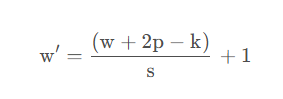

In [142]:
encoder = torch.nn.Sequential(
    Block(3, 32, True),  # b, 32, 31, 31
    Block(32, 64, True), # b, 64, 15, 15 
    Block(64, 128, True),  # b, 128, 7, 7
    Block(128, 256, True),  # b, 256, 3, 3
    torch.nn.Flatten(),  # b, 2304
    torch.nn.Linear(2304, 128)  # b, 128
)

In [117]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(128, 256 * 4 * 4),
    torch.nn.InstanceNorm1d(256 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
    Block(256, 128, False),
    Block(128, 64, False),
    Block(64, 32, False),
    Block(32, 3, False),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(3, 3, kernel_size=1, stride=1, padding=0),
    torch.nn.Tanh()
)
decoder(torch.randn(2, 128)).shape

torch.Size([2, 3, 64, 64])

In [118]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1,  end_factor=0, total_iters=1000* len(loader))
criterion = torch.nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
decoder.to(device)
encoder.train()
decoder.train()
device

'cuda'

0 0.46038302779197693 0.00019979999999999992


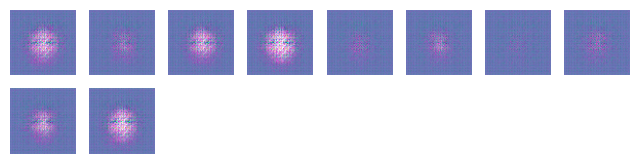

50 0.18737362325191498 0.00018979999999999567


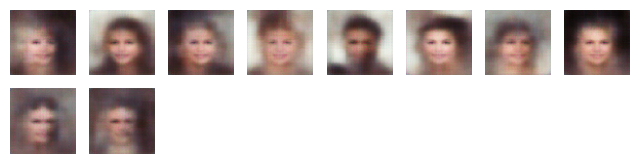

100 0.13813582062721252 0.00017979999999999136


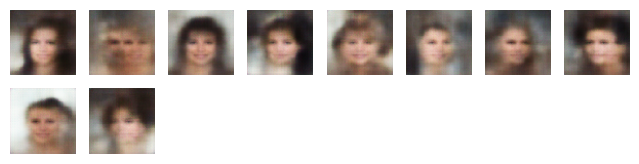

150 0.14427131414413452 0.00016979999999998705


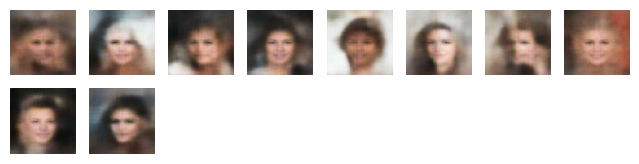

200 0.11369137465953827 0.00015979999999998274


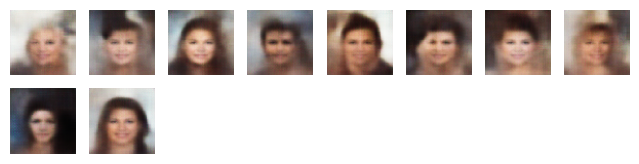

250 0.09544163197278976 0.00014979999999997843


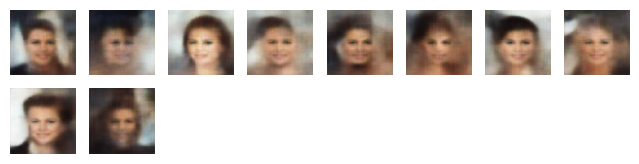

300 0.1431899219751358 0.00013979999999997412


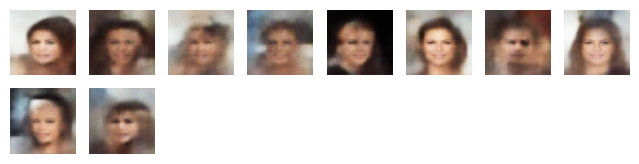

350 0.07687017321586609 0.00012979999999996982


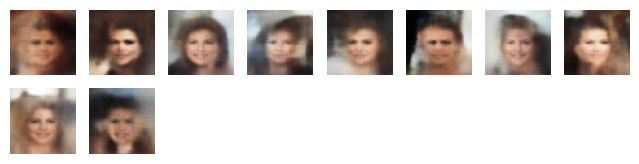

400 0.08948445320129395 0.00011979999999996705


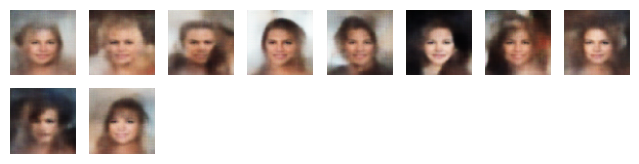

450 0.08759316056966782 0.00010979999999996942


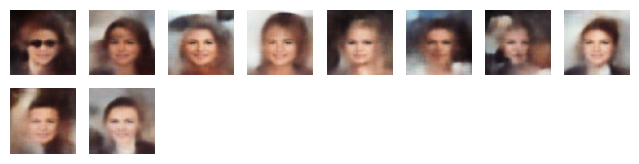

500 0.06728562712669373 9.979999999997104e-05


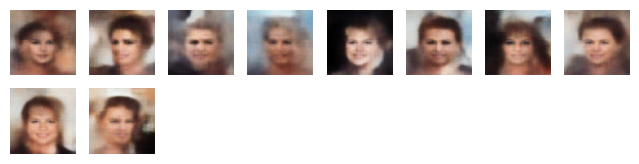

550 0.14999160170555115 8.979999999997328e-05


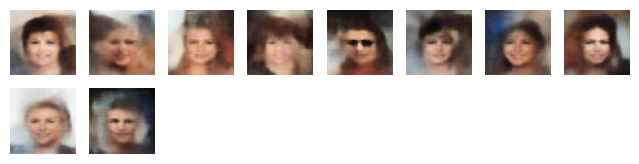

600 0.06343661993741989 7.97999999999742e-05


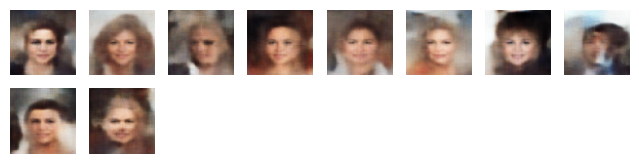

650 0.0554441437125206 6.97999999999755e-05


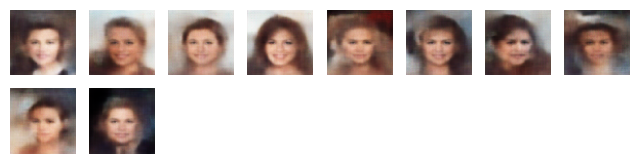

700 0.06421917676925659 5.979999999997737e-05


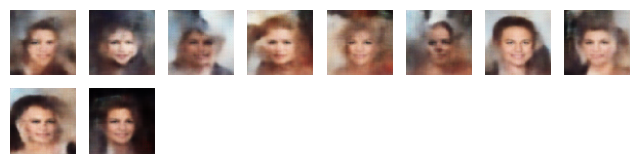

750 0.06131744384765625 4.979999999998155e-05


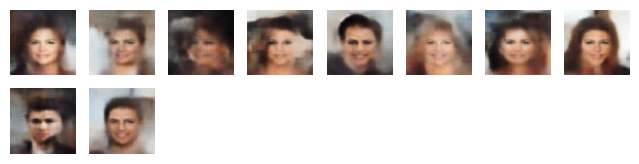

800 0.054441697895526886 3.9799999999986175e-05


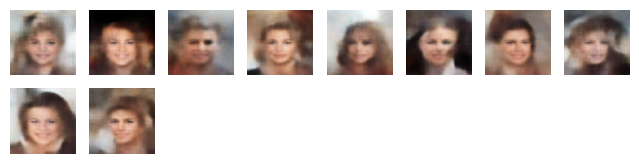

850 0.07026843726634979 2.979999999999099e-05


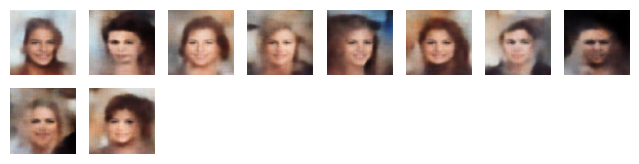

900 0.058854859322309494 1.9799999999993763e-05


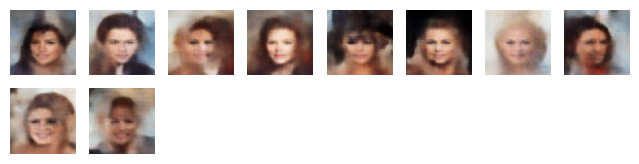

950 0.054628606885671616 9.799999999996925e-06


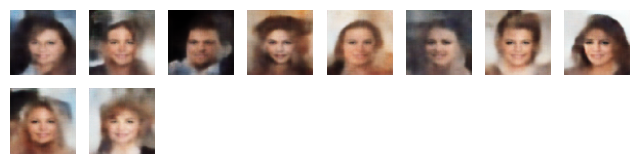

In [119]:
def train():
    for epoch in range(1000):
        for _, data in enumerate(loader):
            data = data.to(device)
            pred = decoder(encoder(data))
            loss = criterion(pred, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        if epoch % 50 == 0:
            print(epoch, loss.item(), optimizer.param_groups[0]['lr'])
            with torch.no_grad():
                gen = decoder(torch.randn(10, 128, device=device))
            show(gen)
train()